# tensorflow自编码
1. 基本自动编码器
2. 图像去噪
3. **异常检测**

# 基本自动编码器

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist,cifar10
from tensorflow.keras.models import Model

In [ ]:
(x_train,_),(x_test,_) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:

# x_test =x_test[:-1]
x_test.shape

(10000, 28, 28)

In [ ]:
# 压缩为54维潜在向量
latent_dim = 64
class AutoEncoder01(Model):
  def __init__(self,latent_dim):
    super(AutoEncoder01,self).__init__()
    self.latent_dim = latent_dim
    #编码器
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])

    # 解码器
    # bs：最后的结构是图片尺寸32
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AutoEncoder01(latent_dim)

In [ ]:
autoencoder.compile(optimizer='adam',loss=losses.MeanSquaredError())

In [ ]:
# autoencoder.summary()

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0239 - val_loss: 0.0092
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.004

In [ ]:
encoded_images = autoencoder.encoder(x_test).numpy()
decoded_images = autoencoder.decoder(encoded_images).numpy()


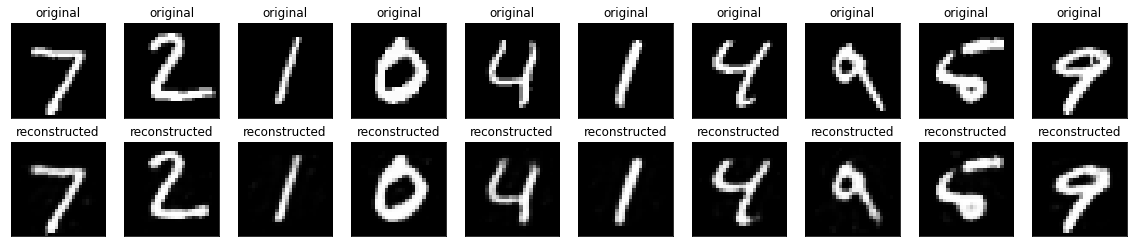

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  # 原始图片
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  # 解码器输出的图片
  plt.imshow(decoded_images[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# 图像去噪


In [ ]:
(x_train,_),(x_test,_) = mnist.load_data()

In [ ]:

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# 添加通道,为的是增加噪声
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [ ]:
# 随机添加噪声
noise_factor = 0.2 
x_train_noisy = x_train+noise_factor*tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test+noise_factor*tf.random.normal(shape=x_test.shape)
# 旋转数值
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

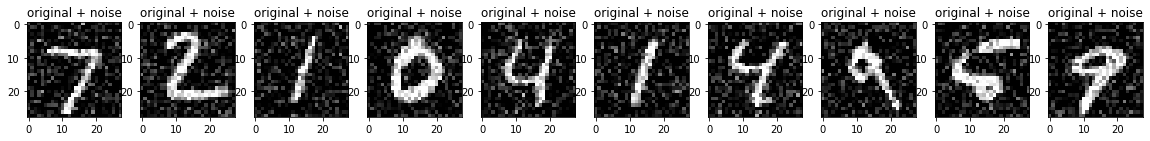

In [ ]:
# 可视化噪声图片
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

定义含有通道的卷积编码器

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise,self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(16,(3,3),activation='relu',padding='same',strides=2),
        layers.Conv2D(8,(3,3),activation='relu',padding='same',strides=2),
    ])

    self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
    ])

  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

denoise = Denoise()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.006

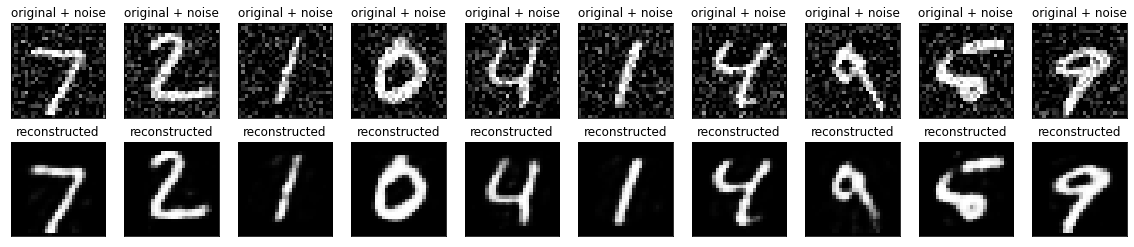

In [ ]:
# 可视化
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# 自定义卷积自动编码器的结构显示


In [ ]:
autoencoder.encoder.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                50240     
                                                                 
Total params: 50,240
Trainable params: 50,240
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.decoder.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 784)               50960     
                                                                 
 reshape_5 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 50,960
Trainable params: 50,960
Non-trainable params: 0
_________________________________________________________________


--------------------------
# 使用cifar10数据集实现卷积自编码器和图像去噪

In [ ]:
(y_train,_),(y_test,_) = cifar10.load_data()
y_train = y_train.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.


In [ ]:
y_train.shape

(50000, 32, 32, 3)

In [ ]:
# this work!
class AutoEncoder01(Model):
  def __init__(self):
    super(AutoEncoder01,self).__init__()
    # self.latent_dim = latent_dim
    #编码器
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(32,32,3)),
        layers.Conv2D(16,(3,3),activation='relu',padding='same',strides=2),
        layers.Conv2D(8,(3,3),activation='relu',padding='same',strides=2),
    ])

    # 解码器
    # bs：最后的结构是图片尺寸32
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded




In [ ]:
class AutoEncoder02(Model):
  def __init__(self):
    super(AutoEncoder02,self).__init__()
    # self.latent_dim = latent_dim
    #编码器
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(32,32,3)),
        layers.Conv2D(8,(3,3),activation='relu',padding='same',strides=2),
    ])

    # 解码器
    # bs：最后的结构是图片尺寸32
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      # 这一步把3通道更改成为了灰度？1为灰度，3位rbg3通道
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
      
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
autoencoder = AutoEncoder02()

In [ ]:
autoencoder.compile(optimizer='adam',loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(y_train, y_train,
                epochs=10,
                shuffle=True,
                validation_data=(y_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0068 - val_loss: 0.0018
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 3/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/10
1563/1563 [==============================] - 7s 4ms/step - loss: 9.7632e-04 - val_loss: 9.1360e-04
Epoch 5/10
1563/1563 [==============================] - 7s 4ms/step - loss: 8.6326e-04 - val_loss: 7.9302e-04
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 7.4846e-04 - val_loss: 6.8198e-04
Epoch 7/10
1563/1563 [==============================] - 7s 5ms/step - loss: 6.4983e-04 - val_loss: 5.9632e-04
Epoch 8/10
1563/1563 [==============================] - 8s 5ms/step - loss: 5.7437e-04 - val_loss: 5.3526e-04
Epoch 9/10
1563/1563 [==============================] - 7s 4ms/step - loss: 5.2316e-04 - val_loss: 5.0879e-04
Epoch 10/10
1563/1563 [===========

In [ ]:
encoded_images = autoencoder.encoder(y_test).numpy()
decoded_images_ci = autoencoder.decoder(encoded_images).numpy()


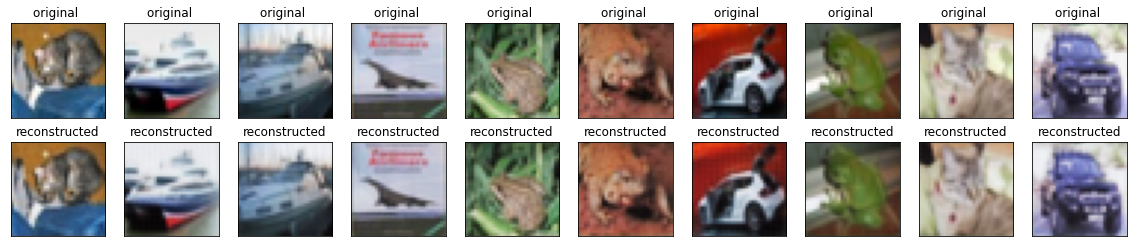

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original ")
    plt.gray()
    plt.imshow(tf.squeeze(y_test[i]))
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_images_ci[i]))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [ ]:
autoencoder.encoder.summary()


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 16, 16, 8)         224       
                                                                 
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.decoder.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_11 (Conv2D  (None, 32, 32, 8)        584       
 Transpose)                                                      
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 3)         219       
                                                                 
Total params: 803
Trainable params: 803
Non-trainable params: 0
_________________________________________________________________


# cif的图像去噪


In [12]:
(y_train,_),(y_test,_) = cifar10.load_data()

y_train = y_train.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.

In [13]:
# 随机添加噪声
noise_factor = 0.1
y_train_noisy = y_train+noise_factor*tf.random.normal(shape=y_train.shape)
y_test_noisy = y_test+noise_factor*tf.random.normal(shape=y_test.shape)


In [14]:
# 旋转数值
y_train_noisy = tf.clip_by_value(y_train_noisy, clip_value_min=0., clip_value_max=1.)
y_test_noisy = tf.clip_by_value(y_test_noisy, clip_value_min=0., clip_value_max=1.)

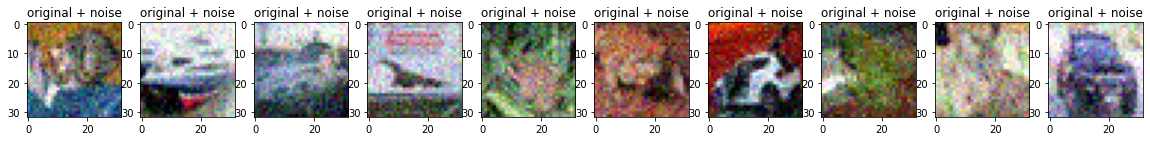

In [15]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(y_test_noisy[i]))
    
plt.show()

In [16]:
y_train.shape

(50000, 32, 32, 3)

In [17]:
y_test_noisy.shape

TensorShape([10000, 32, 32, 3])

In [18]:
y_test.shape

(10000, 32, 32, 3)

In [19]:
# 定义一个卷积自动编码器
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(32, 32, 3)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded



In [20]:
autoencoder = Denoise()

In [21]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [23]:
autoencoder.fit(y_train_noisy, y_train,
                epochs=20,
                shuffle=True,
                validation_data=(y_test_noisy, y_test))

Epoch 1/20
1563/1563 [==============================] - 21s 6ms/step - loss: 0.0095 - val_loss: 0.0051
Epoch 2/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 3/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 4/20
1563/1563 [==============================] - 10s 7ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 5/20
1563/1563 [==============================] - 9s 5ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 6/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 7/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 9/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 10/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0

In [24]:
# 绘制由编码器产生的噪声图片和去噪图像
encoded_imgs = autoencoder.encoder(y_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

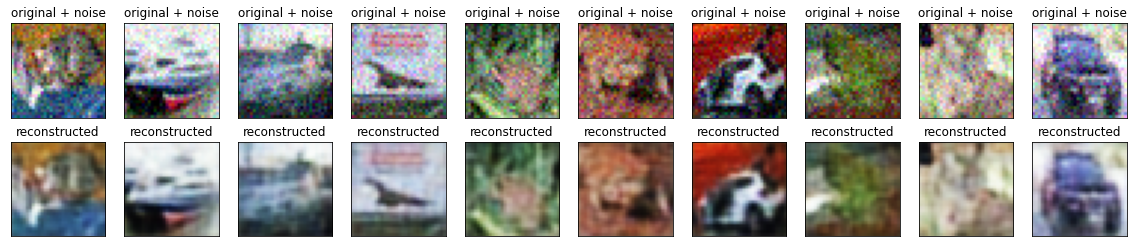

In [25]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(y_test_noisy[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# 异常检测


完成的结果不够好